In [ ]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 15.7 MB/s eta 0:00:0000:0100:01


In [ ]:
# Importing necessary libraries

import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, CLIPModel  , AutoProcessor,MT5Tokenizer,MT5ForConditionalGeneration
from PIL import Image
import faiss
import pickle

import matplotlib.pyplot as plt




# Setting the root path for images and reading captions from a CSV file


In [ ]:
image_root_path='/kaggle/input/flickr30k/Images/'
captions = pd.read_csv('/kaggle/input/flickr30k/captions.txt')


# Initializing CLIP tokenizer, model, and processor

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Initializing MT5 model for translation

In [ ]:
model_size = "base"
model_name = f"persiannlp/mt5-{model_size}-parsinlu-opus-translation_fa_en"
tokenizer_translation = MT5Tokenizer.from_pretrained(model_name)
model_translate= MT5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

# Extracting unique paths for images


In [ ]:
images_path = captions['image'].apply(lambda x :image_root_path+x).unique()


# Function to process image dataset and extract embeddings


In [ ]:
def ProcessImageDataSet(image_infos):
    images_embeds = []
    for image_info in tqdm (image_infos,desc="Processing", unit="item"):
        current_image = Image.open(image_info)
        image_inputs = processor(images=current_image, return_tensors="pt", padding=True)
        image_feature = model.get_image_features(**image_inputs).detach().cpu().numpy()
        images_embeds.extend(image_feature)
        #self.save_images(image_feature,image_info)
        current_image.close()
    return np.stack(images_embeds)


# Processing image dataset and obtaining embeddings


In [ ]:
embeds = ProcessImageDataSet(images_path[:8000])


Processing: 100%|██████████| 8000/8000 [22:54<00:00,  5.82item/s]


# Save embeding to pickle

In [ ]:
with open('flicker30k_image_embeddings.pkl','wb') as f:
    pickle.dump(embeds, f)

# Load embeding from pickle

In [ ]:
with open('/kaggle/working/flicker30k_image_embeddings.pkl', 'rb') as fp:
    embeds = pickle.load(fp)


# Building an index for similarity search using Faiss


In [ ]:
index = faiss.IndexFlatIP(embeds.shape[1])
index.add(embeds)


# Function to embed queries and Function to run translation model and translate queries

In [ ]:
def queray_embeding(queary):
    queary_embed=[]
    tokenized_caps = tokenizer(queary, padding=True, return_tensors="pt")
    text_feature = model.get_text_features(**tokenized_caps).detach().cpu().numpy()
    queary_embed.extend(text_feature)
    return np.stack(queary_embed)
def run_translation_model(input_string, **generator_args):
    print(input_string)
    input_ids = tokenizer_translation.encode(input_string, return_tensors="pt")
    res = model_translate.generate(input_ids, **generator_args)
    output = tokenizer_translation.batch_decode(res, skip_special_tokens=True)
    print(output)
    return str(output[0])

# Defining, Embedding and Normalizing the query

In [ ]:
queary = 'سگی در حال دویدن'
#embeding
queary_embed = queray_embeding(run_translation_model(queary))
#normizli
queary_embed = queary_embed/np.linalg.norm(queary_embed, ord=2, axis=-1, keepdims=True)


سگی در حال دویدن


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1128: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['A dog running']


# Searching for similar images based on the query embedding


In [ ]:
distances, indices = index.search(queary_embed.reshape(1, -1), 5)
distances = distances[0]
indices = indices[0]

# Combining indices and distances for ranking


In [ ]:
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

print(indices_distances)

[(5800, 3.595748), (3866, 3.6299472), (3999, 3.6350524), (6453, 3.6378512), (4729, 3.660084)]


# Displaying similar images


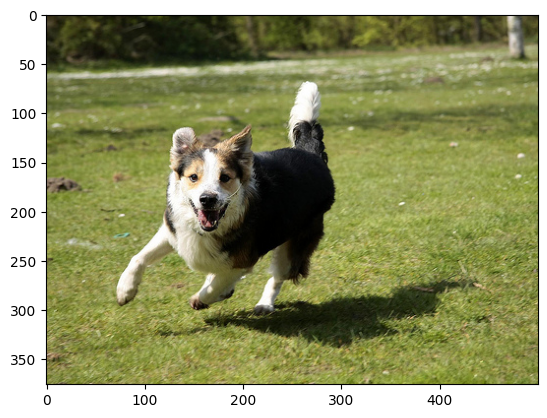

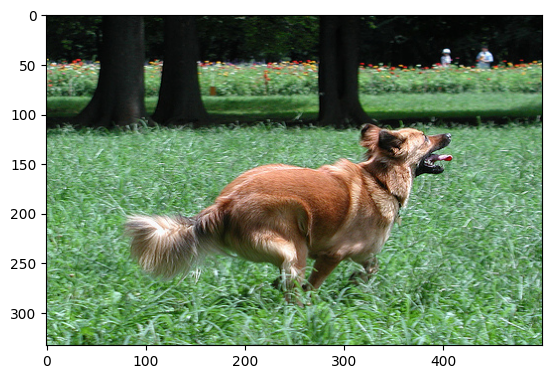

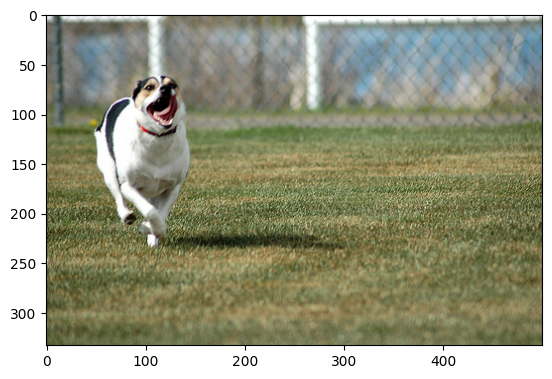

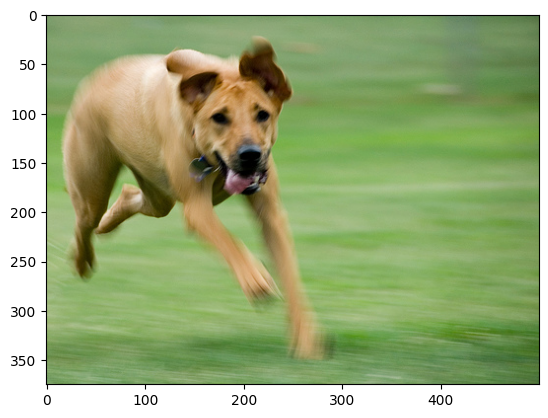

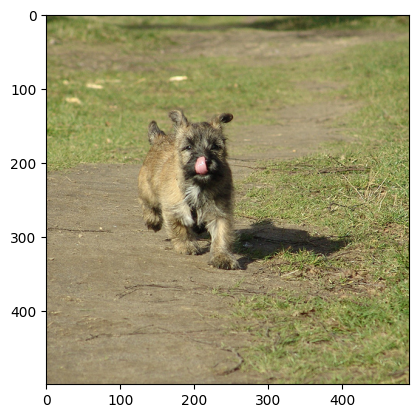

In [ ]:

for idx, distance in indices_distances:
    path = images_path[idx]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()